# Project Topic

The goal in this Kaggle competition is to create an algorithm to identify metastatic cancer in patches from digital pathology scans. The provided dataset was clean, without empty fields or duplicates.

This notebook describes the creation of a convolutional neural network (CNN) as a model for discriminating between positive and negative metastatic cancer outcomes based on the images.

In [1]:
#Load the modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import cv2
import os
import tensorflow.keras.utils
import tqdm
import gc

from glob import glob
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.models import load_model
from keras.models import Sequential
from numpy.random import seed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import set_random_seed
from tqdm.notebook import tqdm

I previously downloaded the testing, training, and label files from Kaggle. Based on discussions on our class's Slack channel, I learned that we can produce an effective model using a fraction of the enormous set of image files in the training set.

I used a personal Google Colab Pro for the project, which meant that it pulled data from my Google Drive. I first tried to upload the .tif files into the Goodle Drive, but that's how I learned that Google Drive is undependable with subdirectories containing more than 10,000 files. I split my training data into groups of less than 9,000 files and compressed them into eight zip files.

The next thing I learned was that Colab is very, very slow at reading thousands of files from Google Drive. A note on StackOverflow* showed a faster alternative - unzip the image files directly into a temporary Colab directory. I didn't need eight training zips any more, but they were already uploaded.

* https://stackoverflow.com/questions/62894074/opencv-imread-and-imwrite-too-slow-on-google-drive-using-colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

!unzip "drive/My Drive/histo/train1.zip" -d colabTrain
!unzip "drive/My Drive/histo/train2.zip" -d colabTrain
!unzip "drive/My Drive/histo/train3.zip" -d colabTrain
!unzip "drive/My Drive/histo/train4.zip" -d colabTrain
!unzip "drive/My Drive/histo/train5.zip" -d colabTrain
!unzip "drive/My Drive/histo/train6.zip" -d colabTrain
!unzip "drive/My Drive/histo/train7.zip" -d colabTrain
!unzip "drive/My Drive/histo/train8.zip" -d colabTrain


Archive:  drive/My Drive/histo/train1.zip
replace colabTrain/1a0ca02a379acde51e17060bef3573f0f481a897.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  drive/My Drive/histo/train2.zip
replace colabTrain/10a794d284b55faa972f619ac39af370010b9ef8.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  drive/My Drive/histo/train3.zip
replace colabTrain/3a0cfff177e46778a4440662afc9a4ba9c36e64b.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  drive/My Drive/histo/train4.zip
replace colabTrain/30a006b36f0250b6bb83f4d2bb9247f18e3248ca.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  drive/My Drive/histo/train5.zip
replace colabTrain/5a1b506e9a783419d0a72ce0bd62cf38dcc56f5c.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  drive/My Drive/histo/train6.zip
replace colabTrain/50a572ef909e3504ef928c0d68e0316636626f7d.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  drive/My Drive/histo/train7.zip
replace colabTrain/7a0f48e10b6685c3446a5962d81a0c7590b4e666.tif? [y]es, [n]o

This was my second runthrough, and I was surprised to see that the training files had persisted from the first try. After repeatedly telling Colab not to replace those files, I deleted the testing directory and restored a fresh set of testing files.

In [5]:
!rm -rf "colabTest"

In [8]:
!unzip "drive/My Drive/histo/test.zip" -d colabTest

Streaming output truncated to the last 5000 lines.
  inflating: colabTest/test/e9c2196770338f0230d1009bf4a4f5ebaa1eb772.tif  
  inflating: colabTest/test/e9c2b934fc8094e1bb2481efaceb84f23650c3bb.tif  
  inflating: colabTest/test/e9c44ee18295deeb2bd8e3ff6a19e9866a344c61.tif  
  inflating: colabTest/test/e9c4fa2b91ea2073cd0d441f441ca99130e6b69d.tif  
  inflating: colabTest/test/e9c8e18cc1b0550e37d8c480caf9c35591539dee.tif  
  inflating: colabTest/test/e9ca2fa382044ba4583300ce2effd3eb519d8aa0.tif  
  inflating: colabTest/test/e9ca8b992446737e66500736a37a2e1049cfedd9.tif  
  inflating: colabTest/test/e9cb4f6dda70e84ed023aa24e7a22029cbe65740.tif  
  inflating: colabTest/test/e9cb723ae450a97d0d1c95c790ec828541089ddd.tif  
  inflating: colabTest/test/e9cd03d7dff3b9e5691fa237621d8e99ab3fcecf.tif  
  inflating: colabTest/test/e9cefa195bb47d2b3791b6c31245278726e24985.tif  
  inflating: colabTest/test/e9d08df25252415f238c32fc0a7bb43a98ad945b.tif  
  inflating: colabTest/test/e9d0f4d084afb930b22ca

In [9]:
trainFileNames = glob('colabTrain/*.tif')

In [10]:
dfTrain = pd.DataFrame({'path': trainFileNames})
dfTrain.head()

,path
0,colabTrain/18768dab4bd3ed1272f19ded2e79f450230...
1,colabTrain/156f756ccbeb9b5c4399b9fd2858c15f60c...
2,colabTrain/3aabdee49a632ebd5d2ce2bd012eceacd32...
3,colabTrain/3dcf4052444574d19f3887129a3eb158434...
4,colabTrain/76985e395a4d3c5f7d26bf01bfd783eb7d1...


In [11]:
labels = pd.read_csv("drive/MyDrive/histo/train_labels.csv")
print(labels.shape)

(220025, 2)


I needed both the path for reading each image and the id to match its label.

In [12]:
pathLength = len('colabTrain/')
dfTrain['id'] = dfTrain.path.str[pathLength:]
dfTrain['id'] = dfTrain.id.str[:-4] #trim off the .tif
print(dfTrain.shape)
dfTrain.head()

(55135, 2)


,path,id
0,colabTrain/18768dab4bd3ed1272f19ded2e79f450230...,18768dab4bd3ed1272f19ded2e79f4502301ca4c
1,colabTrain/156f756ccbeb9b5c4399b9fd2858c15f60c...,156f756ccbeb9b5c4399b9fd2858c15f60c9f005
2,colabTrain/3aabdee49a632ebd5d2ce2bd012eceacd32...,3aabdee49a632ebd5d2ce2bd012eceacd325eeb8
3,colabTrain/3dcf4052444574d19f3887129a3eb158434...,3dcf4052444574d19f3887129a3eb15843499968
4,colabTrain/76985e395a4d3c5f7d26bf01bfd783eb7d1...,76985e395a4d3c5f7d26bf01bfd783eb7d1c38ba


In [13]:
dfTrain = dfTrain.merge(labels, on = "id")
dfTrain.head()

,path,id,label
0,colabTrain/18768dab4bd3ed1272f19ded2e79f450230...,18768dab4bd3ed1272f19ded2e79f4502301ca4c,0
1,colabTrain/156f756ccbeb9b5c4399b9fd2858c15f60c...,156f756ccbeb9b5c4399b9fd2858c15f60c9f005,0
2,colabTrain/3aabdee49a632ebd5d2ce2bd012eceacd32...,3aabdee49a632ebd5d2ce2bd012eceacd325eeb8,1
3,colabTrain/3dcf4052444574d19f3887129a3eb158434...,3dcf4052444574d19f3887129a3eb15843499968,0
4,colabTrain/76985e395a4d3c5f7d26bf01bfd783eb7d1...,76985e395a4d3c5f7d26bf01bfd783eb7d1c38ba,0


### Loading the Images

I loaded the training data images, storing their values in numpy arrays along with the target label values.

In [14]:
def loadData(N, df):
    X = np.zeros([N, 96, 96, 3], dtype = np.uint8)
    for idx, row in tqdm(df.iterrows(), total = N):
        if idx == N:
            break
        X[idx] = cv2.imread(row['path'])

    y = np.array(df.label)[0: N]

    return X, y

In [15]:
numFiles = dfTrain["path"].size
X, y = loadData(N = numFiles, df = dfTrain)

  0%|          | 0/55135 [00:00<?, ?it/s]

### Exploratory Data Analysis

Let's start by taking a look at a few of the images.

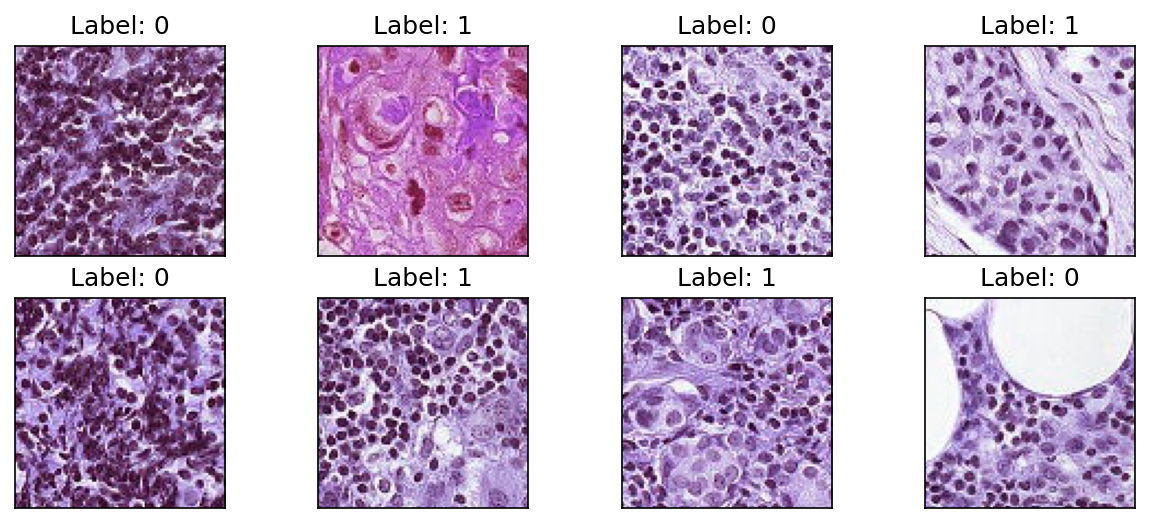

In [16]:
fig = plt.figure(figsize = (10, 4), dpi = 150)
np.random.seed(80)
for plotNr, idx in enumerate(np.random.randint(0, numFiles, 8)):
    ax = fig.add_subplot(2, 8//2, plotNr + 1, xticks = [], yticks = [])
    plt.imshow(X[idx])
    ax.set_title('Label: ' + str(y[idx]))

I can't see any obvious differences.

Next we'll see whether the subset of training images that I chose have a significant imbalance of positives and negatives.

Text(0, 0.5, '# of samples')

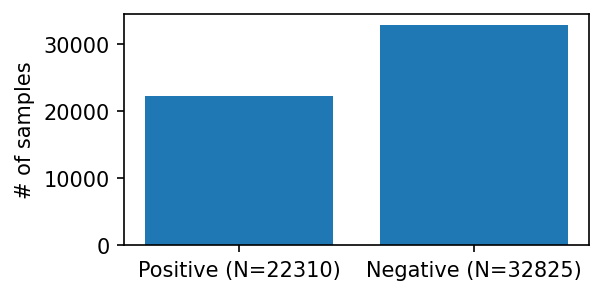

In [17]:
fig = plt.figure(figsize = (4, 2), dpi = 150)
plt.bar([1,0], [(y == 0).sum(), (y == 1).sum()]);
plt.xticks([1,0], ["Negative (N={})".format((y == 0).sum()),"Positive (N={})".format((y == 1).sum())]);
plt.ylabel("# of samples")

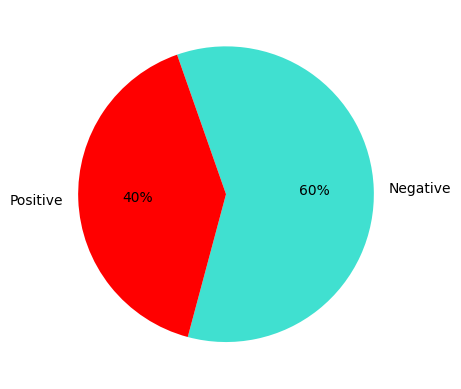

In [18]:
countPositive = dfTrain['label'].value_counts()
pieLabels = ['Negative', 'Positive']
plt.pie(countPositive, labels = pieLabels, startangle = 255, autopct = '%.0f%%', colors = ['turquoise', 'red'])
plt.show()

Having a 40/60 split might not be optimal, but I don't think it's so extreme that it would require intervention.

In [19]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

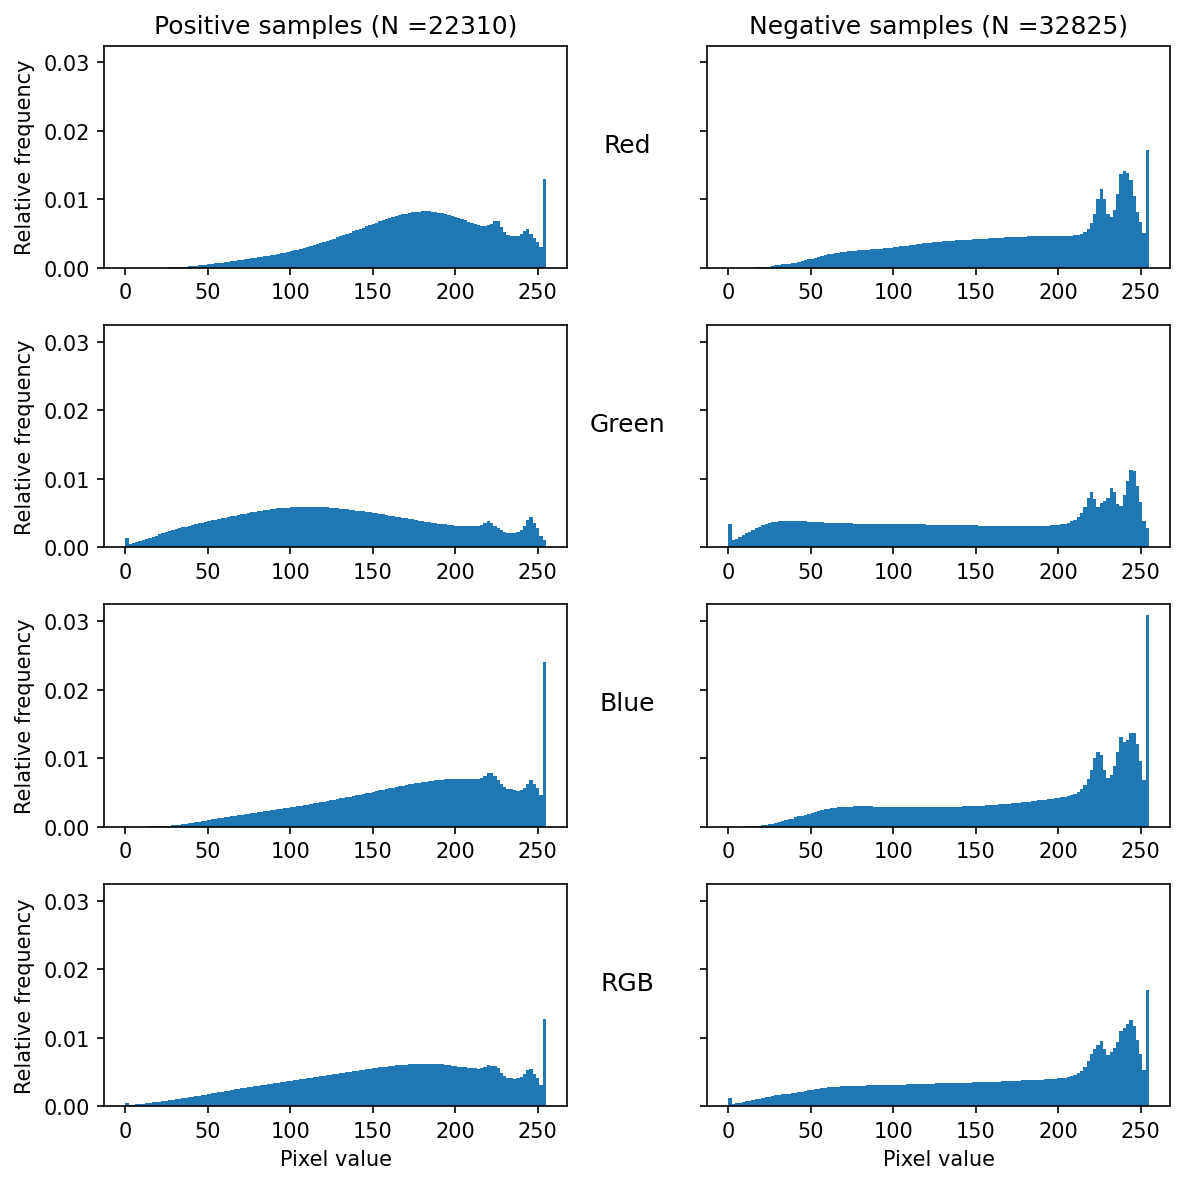

In [20]:
numBins = 128
fig, axs = plt.subplots(4, 2, sharey = True, figsize = (8, 8), dpi = 150)

axs[0, 0].hist(positive_samples[:,:,:,0].flatten(), bins = numBins, density = True)
axs[0, 1].hist(negative_samples[:,:,:,0].flatten(), bins = numBins, density = True)
axs[1, 0].hist(positive_samples[:,:,:,1].flatten(), bins = numBins, density = True)
axs[1, 1].hist(negative_samples[:,:,:,1].flatten(), bins = numBins, density = True)
axs[2, 0].hist(positive_samples[:,:,:,2].flatten(), bins = numBins, density = True)
axs[2, 1].hist(negative_samples[:,:,:,2].flatten(), bins = numBins, density = True)
axs[3, 0].hist(positive_samples.flatten(), bins = numBins, density = True)
axs[3, 1].hist(negative_samples.flatten(), bins = numBins, density = True)

axs[0, 0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0, 1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0, 1].set_ylabel("Red", rotation = 'horizontal', labelpad = 35, fontsize = 12)
axs[1, 1].set_ylabel("Green", rotation = 'horizontal', labelpad = 35, fontsize = 12)
axs[2, 1].set_ylabel("Blue", rotation = 'horizontal',labelpad = 35, fontsize = 12)
axs[3, 1].set_ylabel("RGB", rotation = 'horizontal', labelpad = 35, fontsize = 12)
for eachY in range(4):
    axs[eachY, 0].set_ylabel("Relative frequency")
axs[3, 0].set_xlabel("Pixel value")
axs[3, 1].set_xlabel("Pixel value")
fig.tight_layout()

The color graphs of positive images are significantly different than those of negative images. We'll see that also reflected in mean brightness of the two categories.

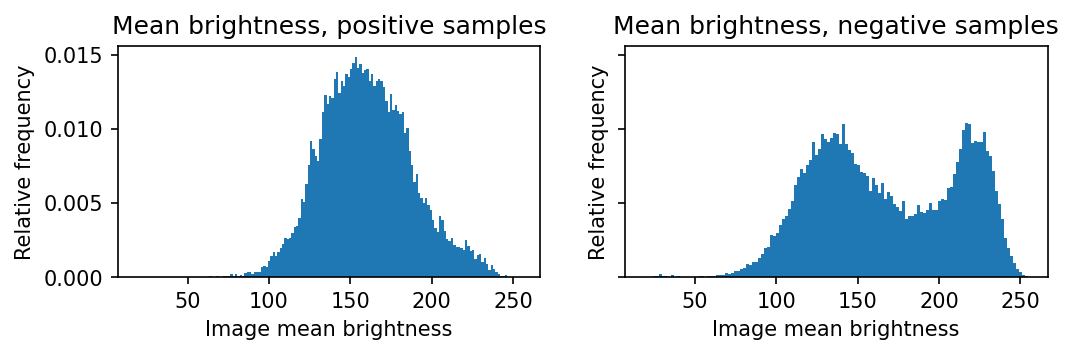

In [21]:
numBins = 128
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True, figsize = (8, 2),dpi = 150)
axs[0].hist(np.mean(positive_samples, axis = (1, 2, 3)), bins = numBins, density = True);
axs[1].hist(np.mean(negative_samples, axis = (1, 2, 3)), bins = numBins, density = True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

In [22]:
positives_samples = None
negative_samples = None
gc.collect();

print(y.shape)

(55135,)


### Split the data, build the model

Because the data involved is so large, I avoided RAM issues by splitting the data by stratifying the existing set rather than creating more sets.

In [23]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state = 5, test_size = 0.2, shuffle = True)

In [25]:
kernel_size = (3, 3)
pool_size= (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.5

seed(5)
set_random_seed(5)

model = Sequential()
model.add(keras.Input(shape=(96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias = False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias = False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias = False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

As you can see below, the model architecture uses three blocks of colvolution and normalization layers.

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 94, 94, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 32)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 92, 92, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 92, 92, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 64)          │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 42, 42, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 19, 19, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 19, 19, 128)         │              

 Total params: 2,386,817 (9.10 MB)

 Trainable params: 2,385,409 (9.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [27]:
batchSize = 32
numEpochs = 20

model.compile(loss = keras.losses.binary_crossentropy,
              optimizer = keras.optimizers.Adam(0.01),
              metrics = ['accuracy'])

checkPath = 'drive/MyDrive/histo/checkpoint.model.keras'
checkPointer = ModelCheckpoint(monitor = 'val_acc', mode = 'max', filepath = checkPath, verbose = 2, save_best_only = True)
earlyStopping = EarlyStopping(monitor = 'val_acc', min_delta = 0, patience = 5, verbose = 0, mode = 'max')

history = model.fit(x = xtrain, y = ytrain, validation_data = (xvalid, yvalid),
                    epochs = numEpochs, batch_size = batchSize, verbose=2, callbacks = [checkPointer, earlyStopping])

Epoch 1/20
1379/1379 - 34s - 25ms/step - accuracy: 0.8085 - loss: 0.4404 - val_accuracy: 0.6237 - val_loss: 1.1466
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1379/1379 - 15s - 11ms/step - accuracy: 0.8345 - loss: 0.3854 - val_accuracy: 0.7035 - val_loss: 0.9246
Epoch 3/20
1379/1379 - 15s - 11ms/step - accuracy: 0.8468 - loss: 0.3616 - val_accuracy: 0.7864 - val_loss: 0.4988
Epoch 4/20
1379/1379 - 15s - 11ms/step - accuracy: 0.8581 - loss: 0.3374 - val_accuracy: 0.8429 - val_loss: 0.3790
Epoch 5/20
1379/1379 - 15s - 11ms/step - accuracy: 0.8699 - loss: 0.3156 - val_accuracy: 0.7142 - val_loss: 0.7351
Epoch 6/20
1379/1379 - 15s - 11ms/step - accuracy: 0.8791 - loss: 0.2990 - val_accuracy: 0.8583 - val_loss: 0.3469
Epoch 7/20
1379/1379 - 15s - 11ms/step - accuracy: 0.8871 - loss: 0.2820 - val_accuracy: 0.7684 - val_loss: 0.5772
Epoch 8/20
1379/1379 - 15s - 11ms/step - accuracy: 0.8908 - loss: 0.2736 - val_accuracy: 0.7680 - val_loss: 0.5588
Epoch 9/20
1379/1379 - 15s - 11ms/step - accuracy: 0.8969 - loss: 0.2627 - val_accuracy: 0.7144 - val_loss: 0.7698
Epoch 10/20
1379/1379 - 15s - 11ms/step - accuracy: 0.8996 - loss: 0.2528 - val_accuracy: 0

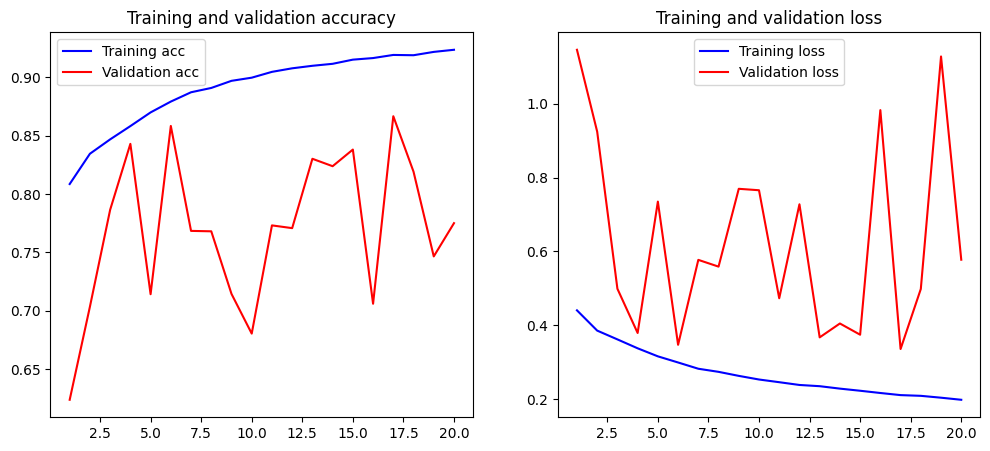

In [28]:
def plotHistory(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label = 'Training acc')
    plt.plot(x, val_acc, 'r', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label = 'Training loss')
    plt.plot(x, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plotHistory(history)

###Results and Analysis

Based on these charts, I think that the optimal number of epochs for this model would have been six. The 17th epoch produced slightly better validation accuracy and loss values, but the smaller number would be a more efficient use of resources and may do more to prevent overfitting.

### Prepare the Submission File

In [31]:
# Reuse the model we trained
testPathLength = len('colabTest/test/')
testFileNames = glob('colabTest/test/*.tif')
dfTest = pd.DataFrame({'path': testFileNames})
dfTest.head()

,path
0,colabTest/test/e176332a2dbb6a702a8e3bccba8346f...
1,colabTest/test/e0edbc953d511083f3c81e433b68e4d...
2,colabTest/test/056916135d0d77554b817240d1d2613...
3,colabTest/test/34fdbb0cf908f41eca34c1727faefda...
4,colabTest/test/bb88f691a2259613bc861618d9ee28f...


In [32]:
dfTest['id'] = dfTest.path.str[testPathLength:]
dfTest['id'] = dfTest.id.str[:-4] #trim off the .tif
print(dfTest.shape)
dfTest.head()

(57458, 2)


,path,id
0,colabTest/test/e176332a2dbb6a702a8e3bccba8346f...,e176332a2dbb6a702a8e3bccba8346f6de7d2b8a
1,colabTest/test/e0edbc953d511083f3c81e433b68e4d...,e0edbc953d511083f3c81e433b68e4d795eceb1b
2,colabTest/test/056916135d0d77554b817240d1d2613...,056916135d0d77554b817240d1d2613993342e12
3,colabTest/test/34fdbb0cf908f41eca34c1727faefda...,34fdbb0cf908f41eca34c1727faefda6e01b5af9
4,colabTest/test/bb88f691a2259613bc861618d9ee28f...,bb88f691a2259613bc861618d9ee28f216563344


In [33]:
dfTest['image'] = dfTest['path'].map(cv2.imread)
K_test = np.stack(dfTest["image"].values)
predArray = model.predict(K_test, verbose = 1)
dfTest['label'] = predArray
print(dfTest.shape)
dfTest.head()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
(57458, 4)


,path,id,image,label
0,colabTest/test/e176332a2dbb6a702a8e3bccba8346f...,e176332a2dbb6a702a8e3bccba8346f6de7d2b8a,"[[[205, 152, 209], [219, 168, 225], [248, 198,...",0.890439
1,colabTest/test/e0edbc953d511083f3c81e433b68e4d...,e0edbc953d511083f3c81e433b68e4d795eceb1b,"[[[249, 232, 255], [33, 0, 34], [61, 7, 42], [...",0.010542
2,colabTest/test/056916135d0d77554b817240d1d2613...,056916135d0d77554b817240d1d2613993342e12,"[[[64, 38, 74], [86, 53, 88], [70, 26, 62], [8...",0.045107
3,colabTest/test/34fdbb0cf908f41eca34c1727faefda...,34fdbb0cf908f41eca34c1727faefda6e01b5af9,"[[[166, 142, 206], [163, 137, 201], [143, 116,...",0.006297
4,colabTest/test/bb88f691a2259613bc861618d9ee28f...,bb88f691a2259613bc861618d9ee28f216563344,"[[[193, 170, 208], [186, 159, 198], [193, 159,...",0.191996


In [34]:
dfSub = dfTest[["id", "label"]]
dfSub.head()

,id,label
0,e176332a2dbb6a702a8e3bccba8346f6de7d2b8a,0.890439
1,e0edbc953d511083f3c81e433b68e4d795eceb1b,0.010542
2,056916135d0d77554b817240d1d2613993342e12,0.045107
3,34fdbb0cf908f41eca34c1727faefda6e01b5af9,0.006297
4,bb88f691a2259613bc861618d9ee28f216563344,0.191996


In [36]:
dfSub.to_csv("/content/drive/My Drive/histo/late_submission.csv", index = False, header = True) #create the submission file

## Conclusion

It's possible to create a reasonably accurate prediction model for digital pathology scans. Retraining the model with an optimal number of epochs could improve its performance.

Other improved solutions could include added stacks of convolution layers and hyperparameter adjustments.